In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint
import itertools

from tqdm import tqdm, trange

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import sklearn.mixture as mixtures
import cv2 as cv

import quinoa as q

In [2]:
NOTEBOOK_NAME = "segment_individual_seeds"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\quinoa\dev
D:\projects\quinoa\data
D:\projects\quinoa\dev\out\segment_individual_seeds


In [3]:
# img_bgr = q.read_image(DATA / "IMG_0477.JPG")
# img_bgr = q.read_image(DATA / "IMG_0497.JPG")
img_bgr = q.read_image(DATA / "IMG_9465.JPG")

print(img_bgr.shape)

DEBUG:quinoa.io:Loaded image from D:\projects\quinoa\data\IMG_9465.JPG


(2432, 3648, 3)


In [4]:
corners = q.find_card_corners(image_bgr=img_bgr)
new_corners = q.determine_new_corners(corners)
crop_slice = q.corners_to_slice(new_corners)
rectifier = q.get_rectifier(corners, new_corners)

img_bgr_cropped = rectifier(img_bgr)[crop_slice]
img_lab_cropped = q.convert_colorspace(img_bgr_cropped, cv.COLOR_BGR2LAB)

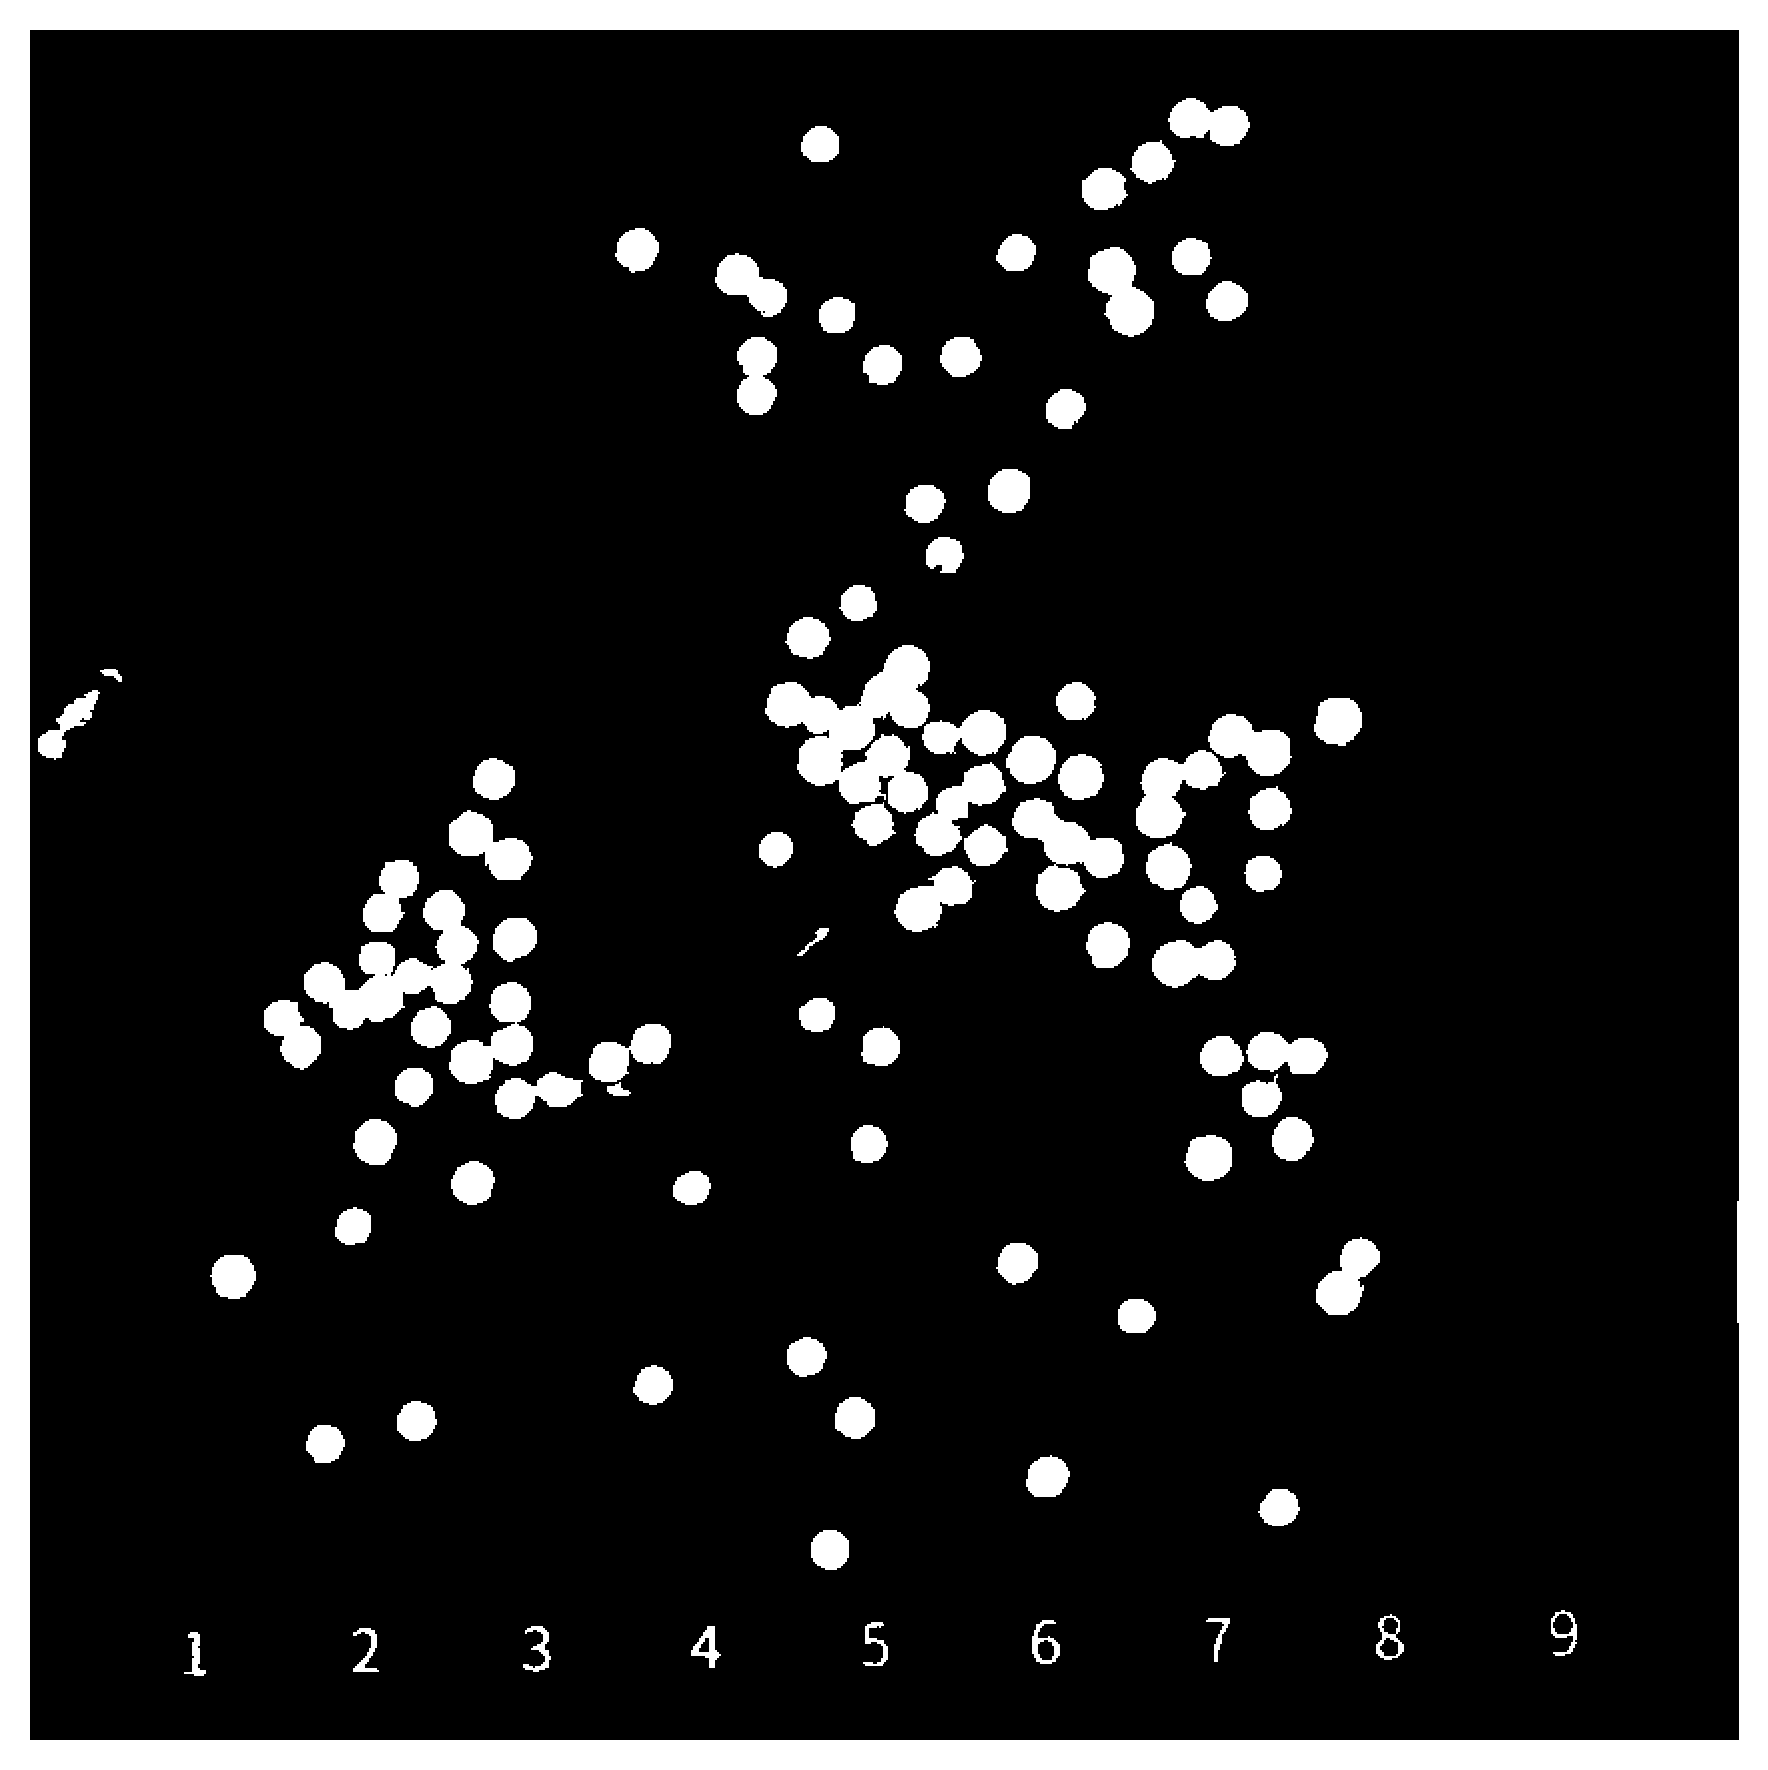

In [5]:
seed_mask, good_markers, seed_labels = q.find_seed_mask(img_lab_cropped)

q.show_image(seed_mask)

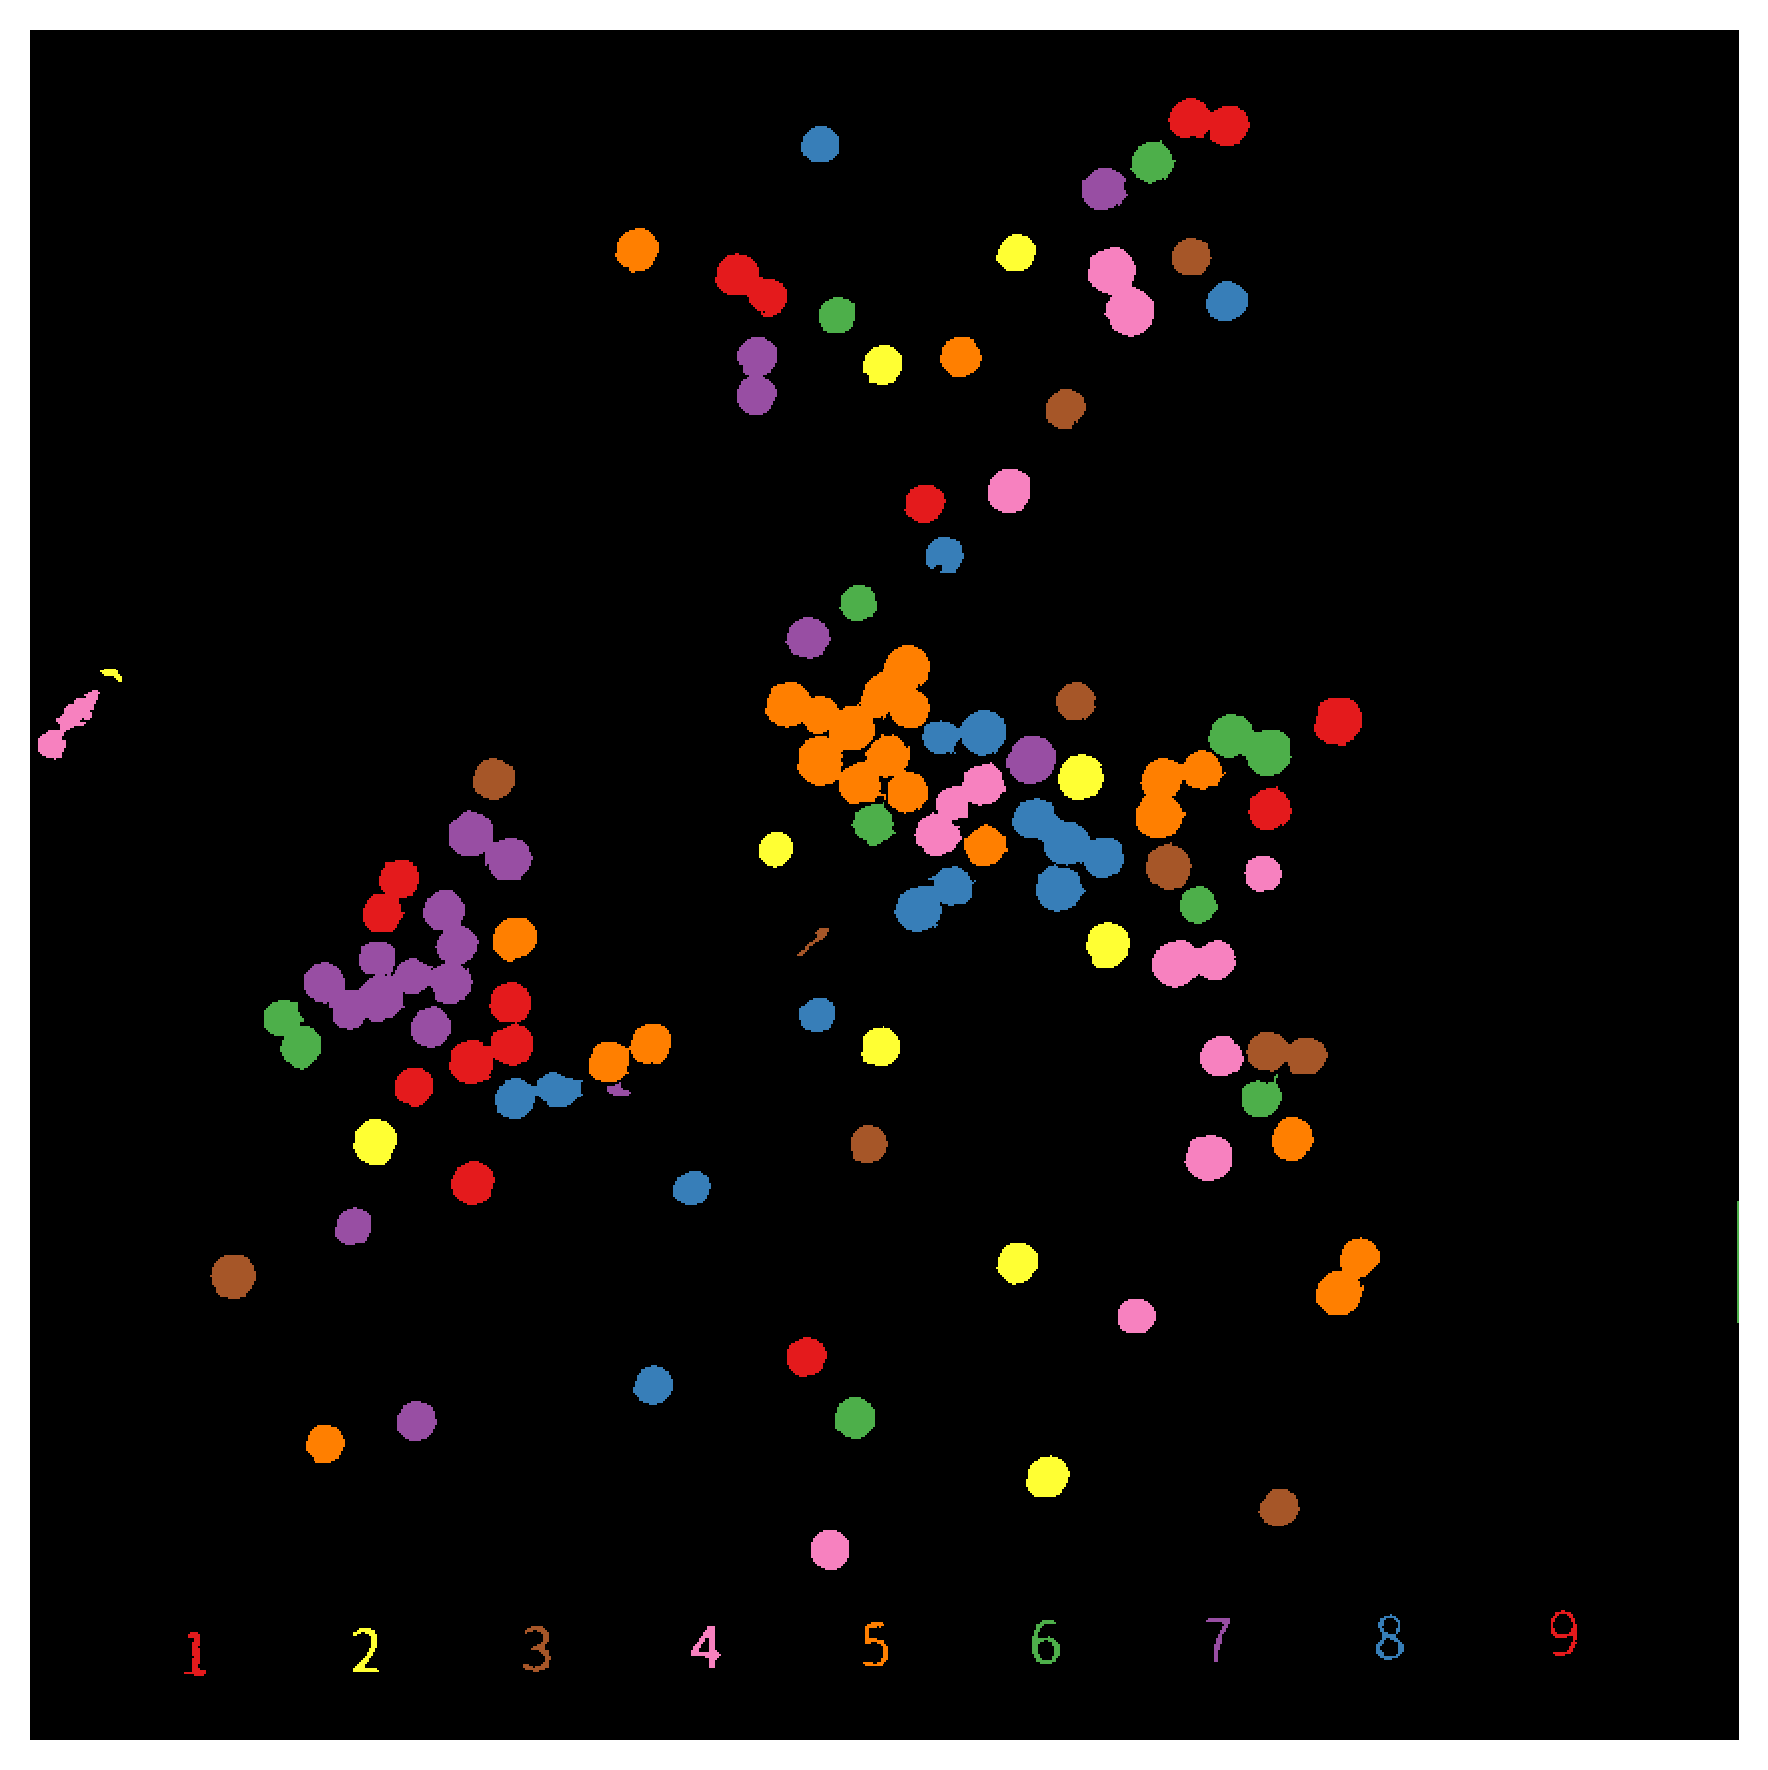

In [6]:
q.show_image(q.color_labels(img_lab_cropped, good_markers, seed_labels))

In [7]:
areas = np.array([
    np.count_nonzero(seed_labels == marker)
    for marker in good_markers
], dtype = np.float64)
print(areas)

[ 661.  277.  339.  372.  370.  290.  300.  894.  638.  324.  271.  618.
  323.  317.  305.  385.  301.  264.  262.  347. 3539.   40.  296.  385.
  458.  658.  798.  462. 1049.  409.  342.  924.  353. 1492.  330.  794.
  327.  236.  402.  265.  618.  727.  268. 2494.  375.  392.   52.  739.
 1074.  248.  607.  320.  672.  312.  624.  340.  303.  644.  313.   49.
  354.  391.  283.  432.  366.  251.   61.  270.  704.  328.  394.  270.
  307.  296.  333.  311.  297.  352.  293.  311.  102.  115.  126.   73.
  101.  108.  116.  129.   97.]


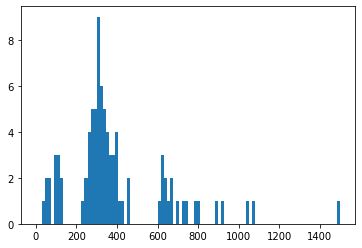

In [8]:
plt.hist(areas, range = (0, 1500), bins = 100)
plt.show()

In [9]:
print(np.median(areas))

328.0


In [10]:
# show_areas = img_bgr_cropped.copy()
# for marker, area in zip(good_markers, areas):
#     y, x = np.transpose(np.nonzero(seed_labels == marker))[0]
#     show_areas = q.draw_text(show_areas, (x, y), str(area), size=0.5)

# print(len(areas))

# q.show_image(show_areas)

In [11]:
# count the number that HAVE THIS AREA (roughly)

sums = []
for area in areas:
    ratios = areas / area
    rounded = np.round(ratios)
    sums.append(np.count_nonzero(rounded == 1))
sums = np.array(sums)

print(sums)

[38 52 55 55 55 53 53 20 44 55 51 49 55 55 53 55 53 50 49 55  2  3 53 55
 64 39 23 64 19 56 55 18 55  7 55 23 55 42 55 50 49 32 50  3 55 55  5 31
 19 45 50 55 37 55 46 55 53 43 55  5 55 55 52 61 55 47  5 51 33 55 55 51
 54 53 55 55 53 55 53 55 11 10  9  9 11 10 10  9 12]


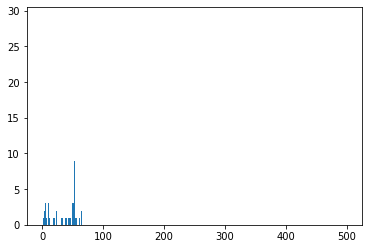

In [12]:
plt.hist(sums, range = (0, 500), bins = 500)
plt.show()

In [13]:
most_common_sum = stats.mode(sums)
print(most_common_sum)
mode = most_common_sum.mode[0]
print(mode)

ModeResult(mode=array([55]), count=array([29]))
55


In [14]:
singleton_markers = [idx for s, idx in zip(sums, good_markers) if s == mode]

print(len(singleton_markers))
print(singleton_markers)

29
[18, 20, 22, 27, 33, 36, 44, 54, 59, 67, 69, 71, 74, 76, 88, 89, 98, 102, 104, 108, 110, 111, 114, 120, 121, 131, 132, 136, 139]


In [15]:
areas_of_singletons = np.array([
    np.count_nonzero(seed_labels == marker)
    for marker in singleton_markers
])

print(areas_of_singletons)

[339 372 370 324 323 317 385 347 385 342 353 330 327 402 375 392 320 312
 340 313 354 391 366 328 394 333 311 352 311]


In [16]:
seed_area = np.mean(areas_of_singletons)
# seed_area = np.median(areas)

print(seed_area)

348.55172413793105


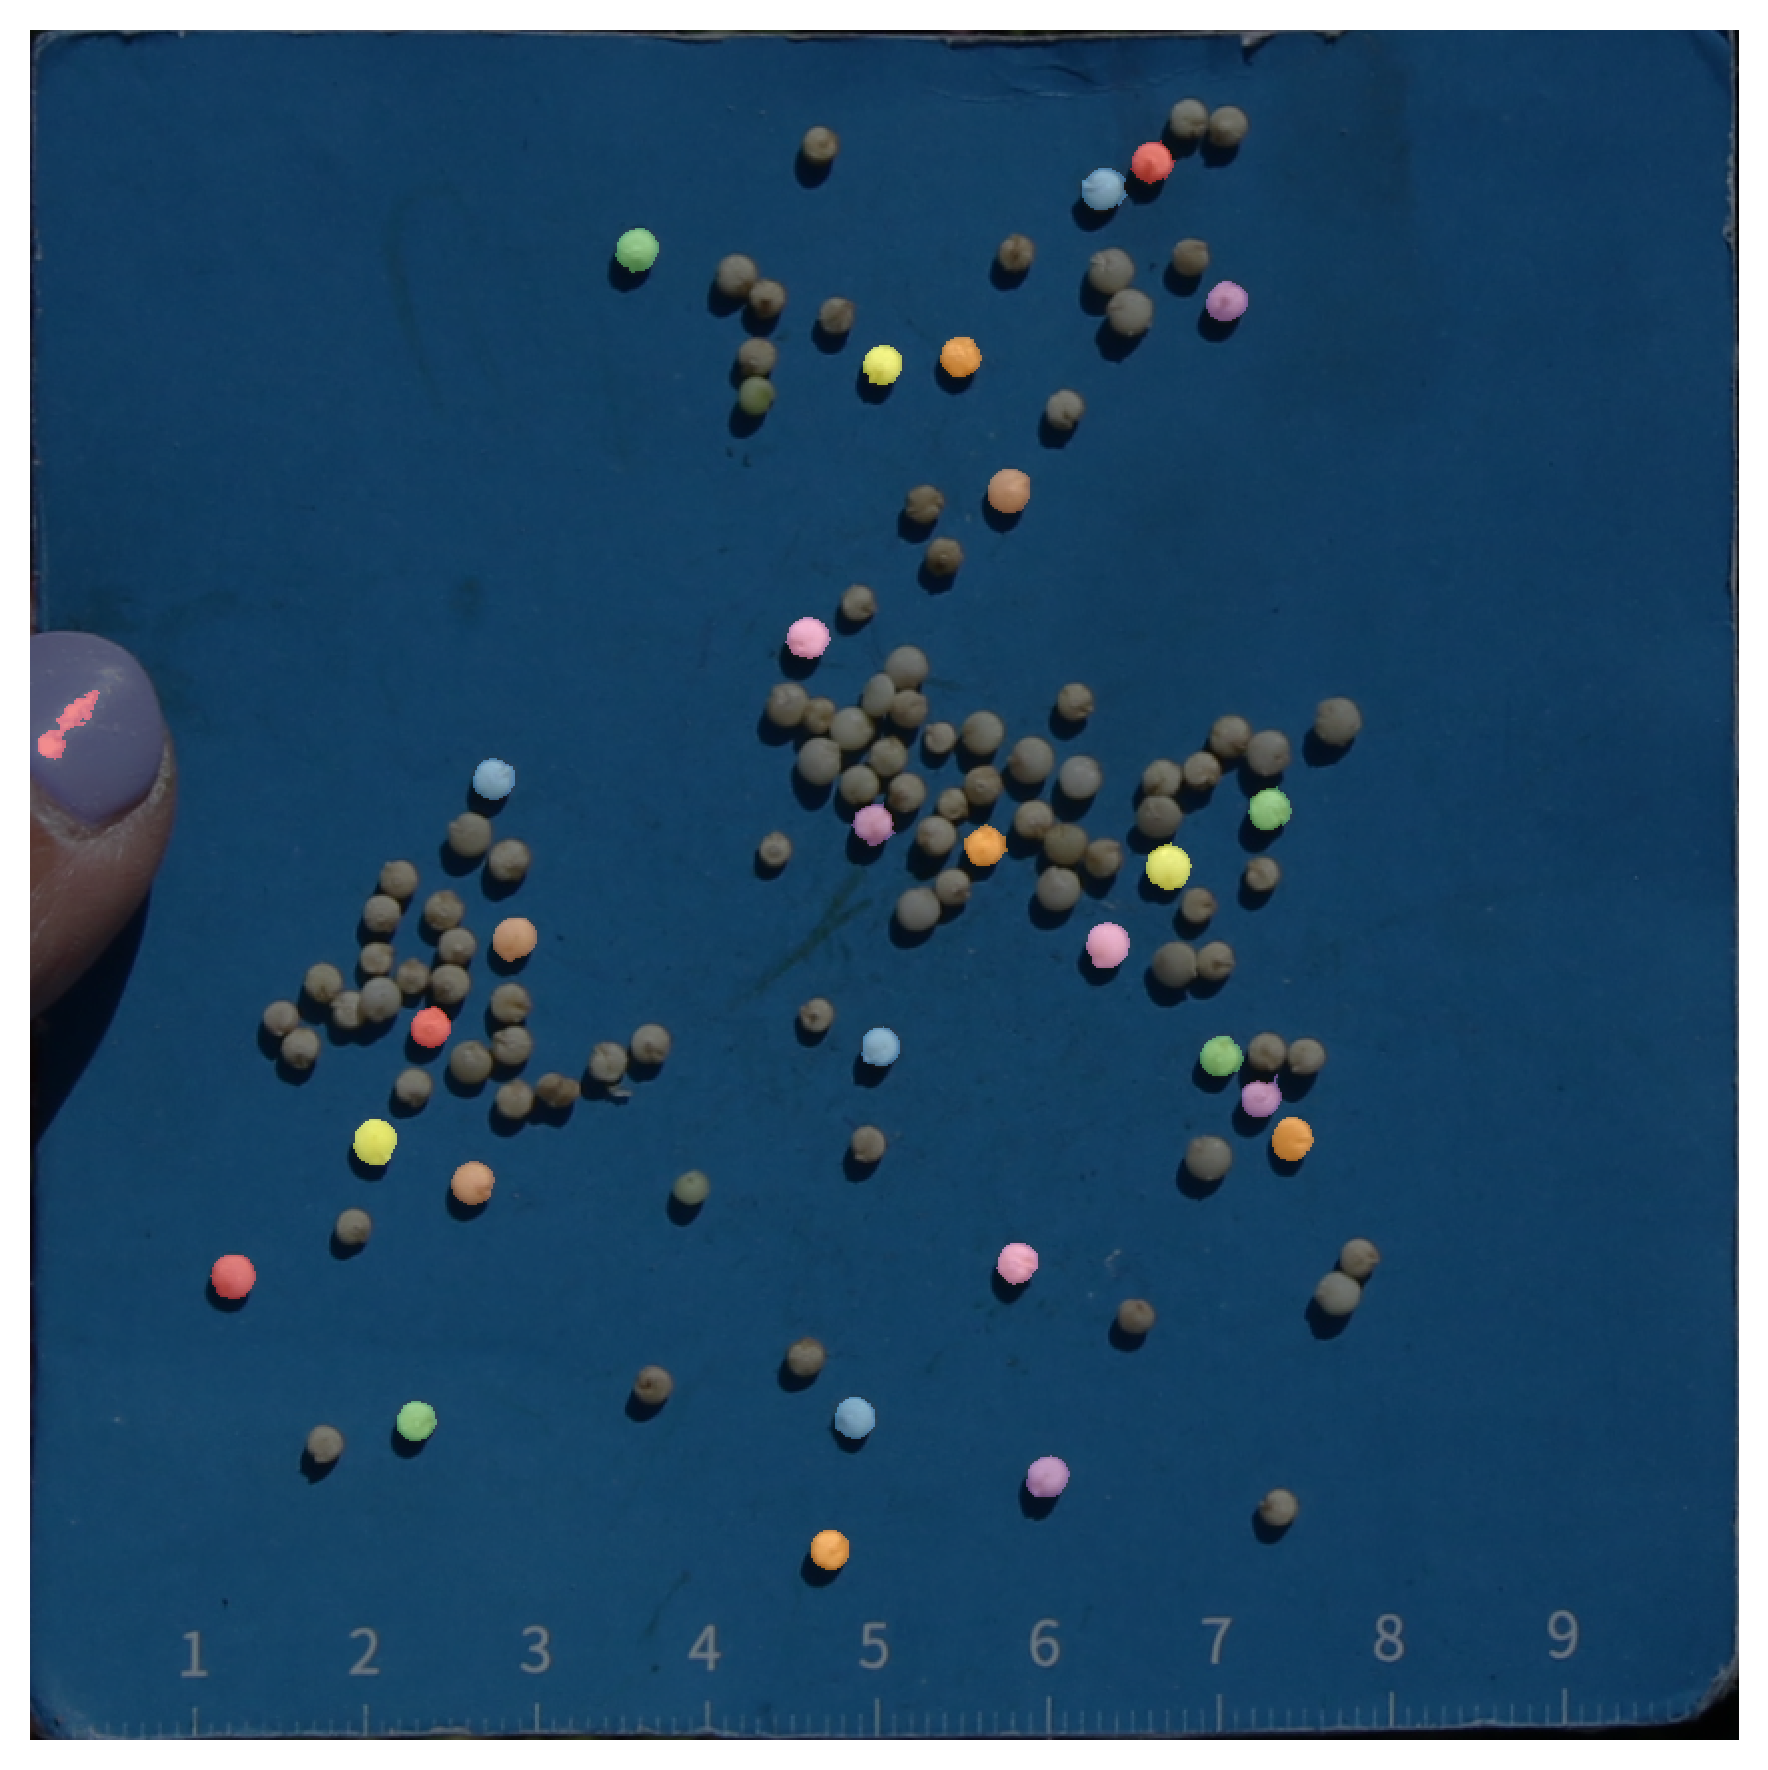

In [17]:
show_single_seeds = q.color_labels(img_bgr_cropped, singleton_markers, seed_labels)

q.show_image(q.overlay_image(img_bgr_cropped, show_single_seeds, 0.5))

In [18]:
areas_of_singletons_again = []
for marker, area in zip(good_markers, areas):
    ratio = int(np.round(area / seed_area))
    if ratio == 1:
        areas_of_singletons_again.append(area)
        
better_seed_area = np.mean(areas_of_singletons_again)
print(better_seed_area)

327.6727272727273


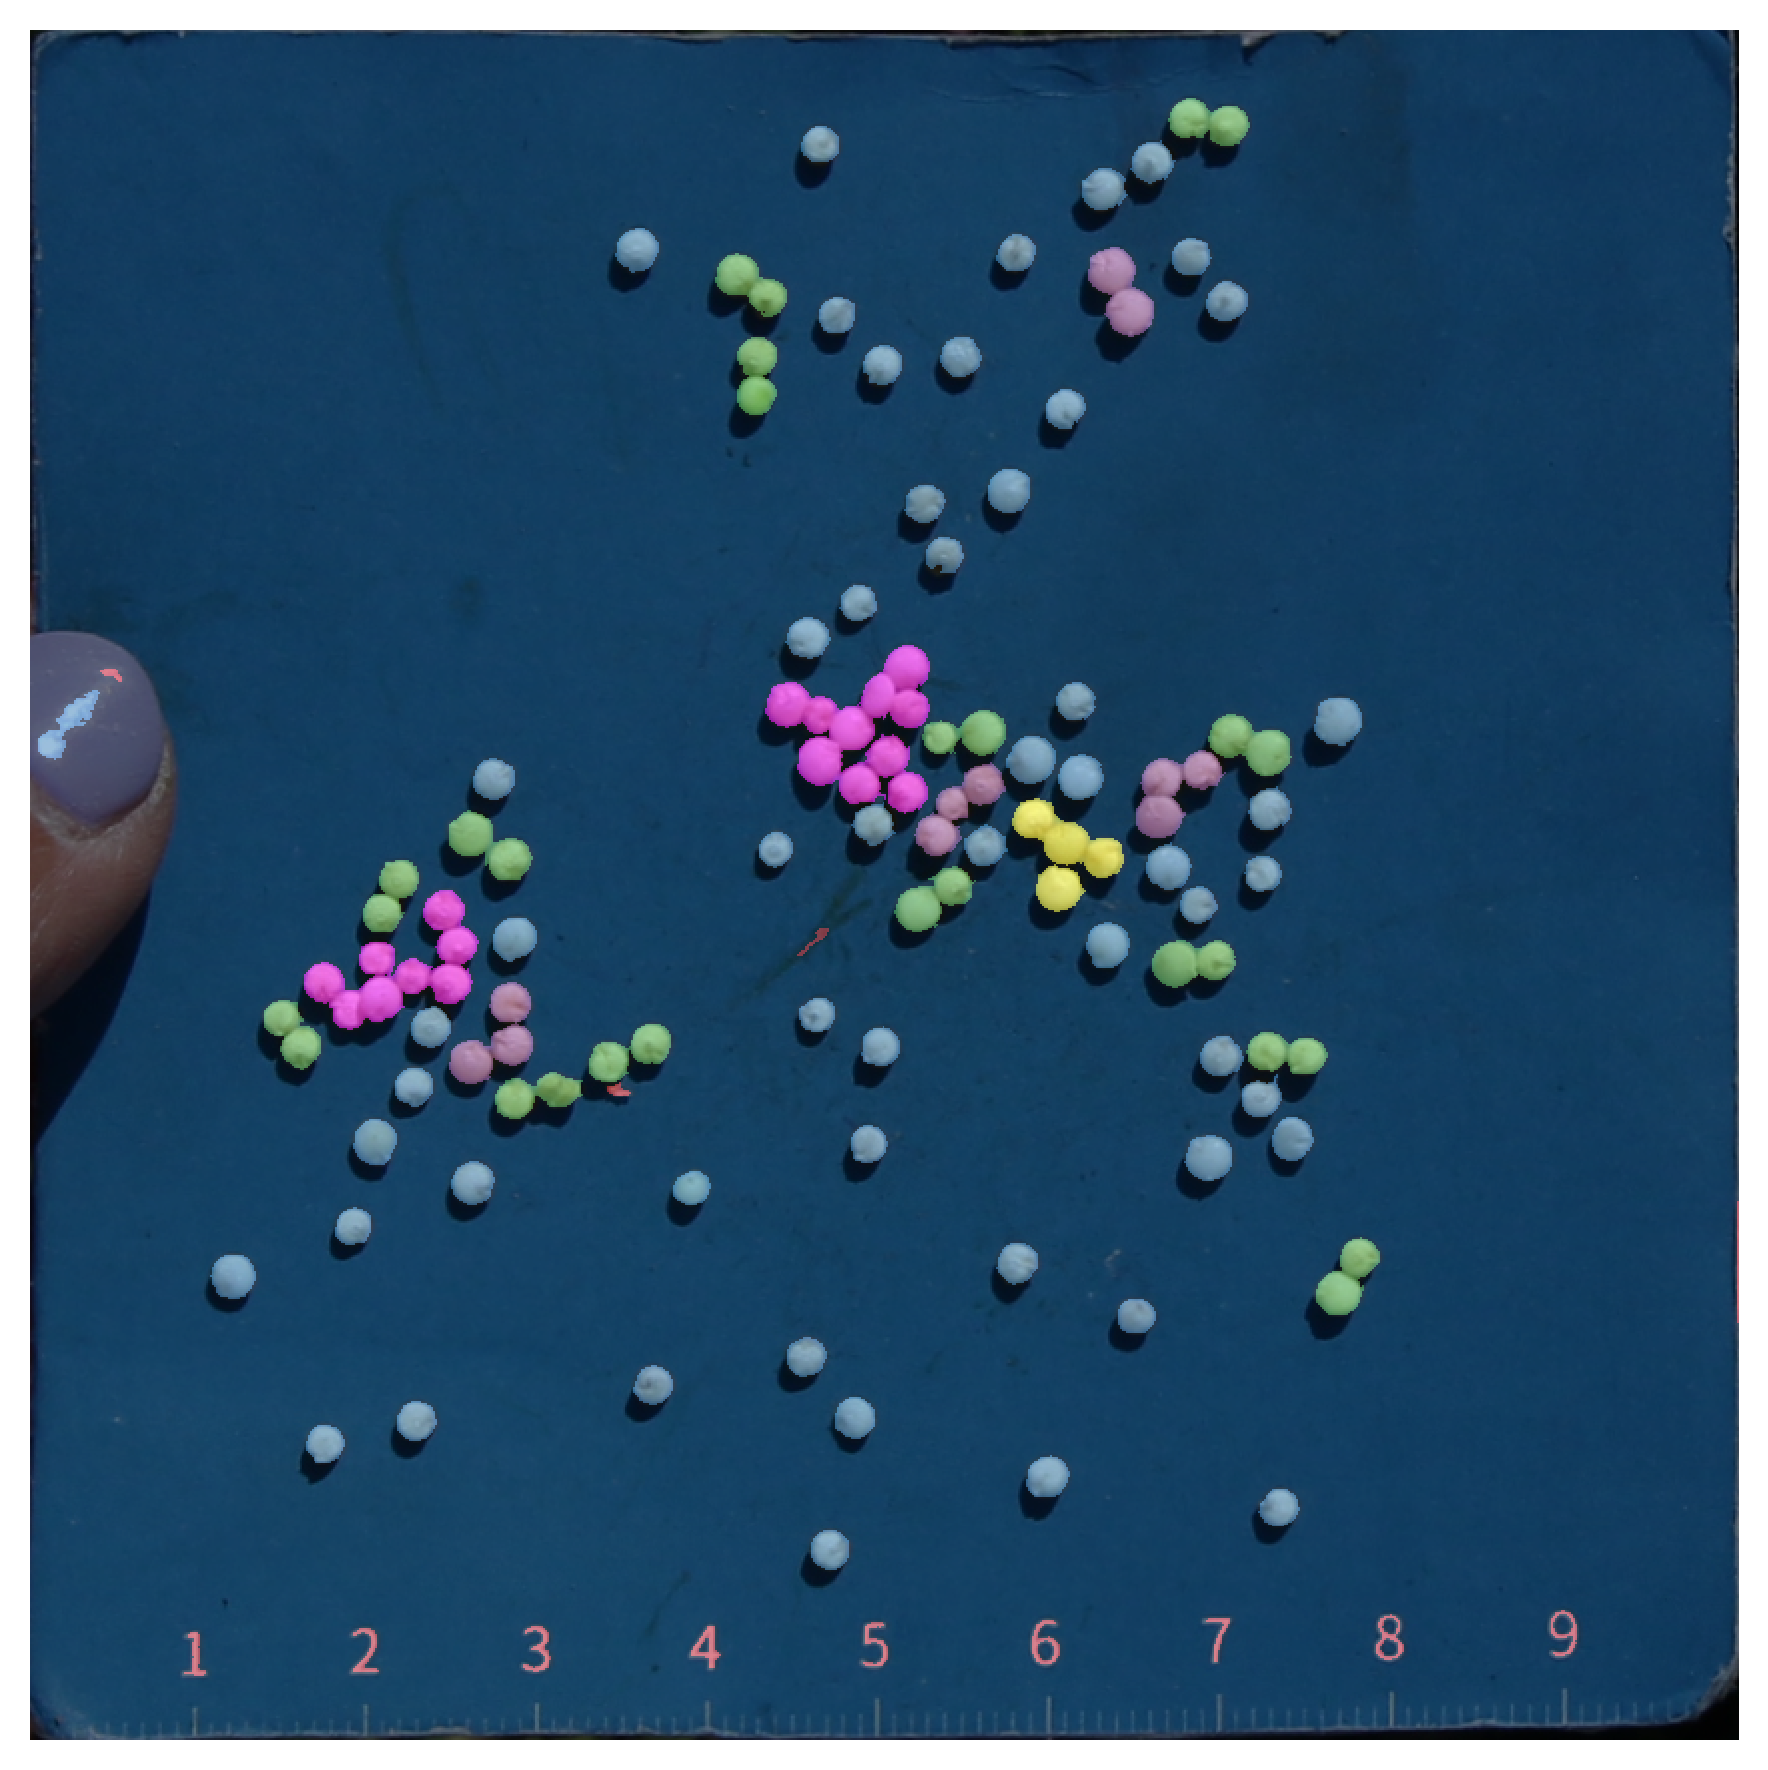

In [19]:
show_counts = np.zeros_like(img_bgr_cropped)

for marker, area in zip(good_markers, areas):
    ratio = int(np.round(area / better_seed_area))
    show_counts[marker == seed_labels] = q.BGR_COLORS[ratio] if ratio < len(q.BGR_COLORS) else q.MAGENTA

q.show_image(q.overlay_image(img_bgr_cropped, show_counts))

In [20]:
marker_contours = {}
for marker in good_markers:
    x = np.where(seed_labels == marker, 255, 0).astype(np.uint8)
    contours, hierarchy = cv.findContours(x, mode = cv.RETR_EXTERNAL, method = cv.CHAIN_APPROX_NONE)

    contour = contours[0]

    marker_contours[marker] = contour

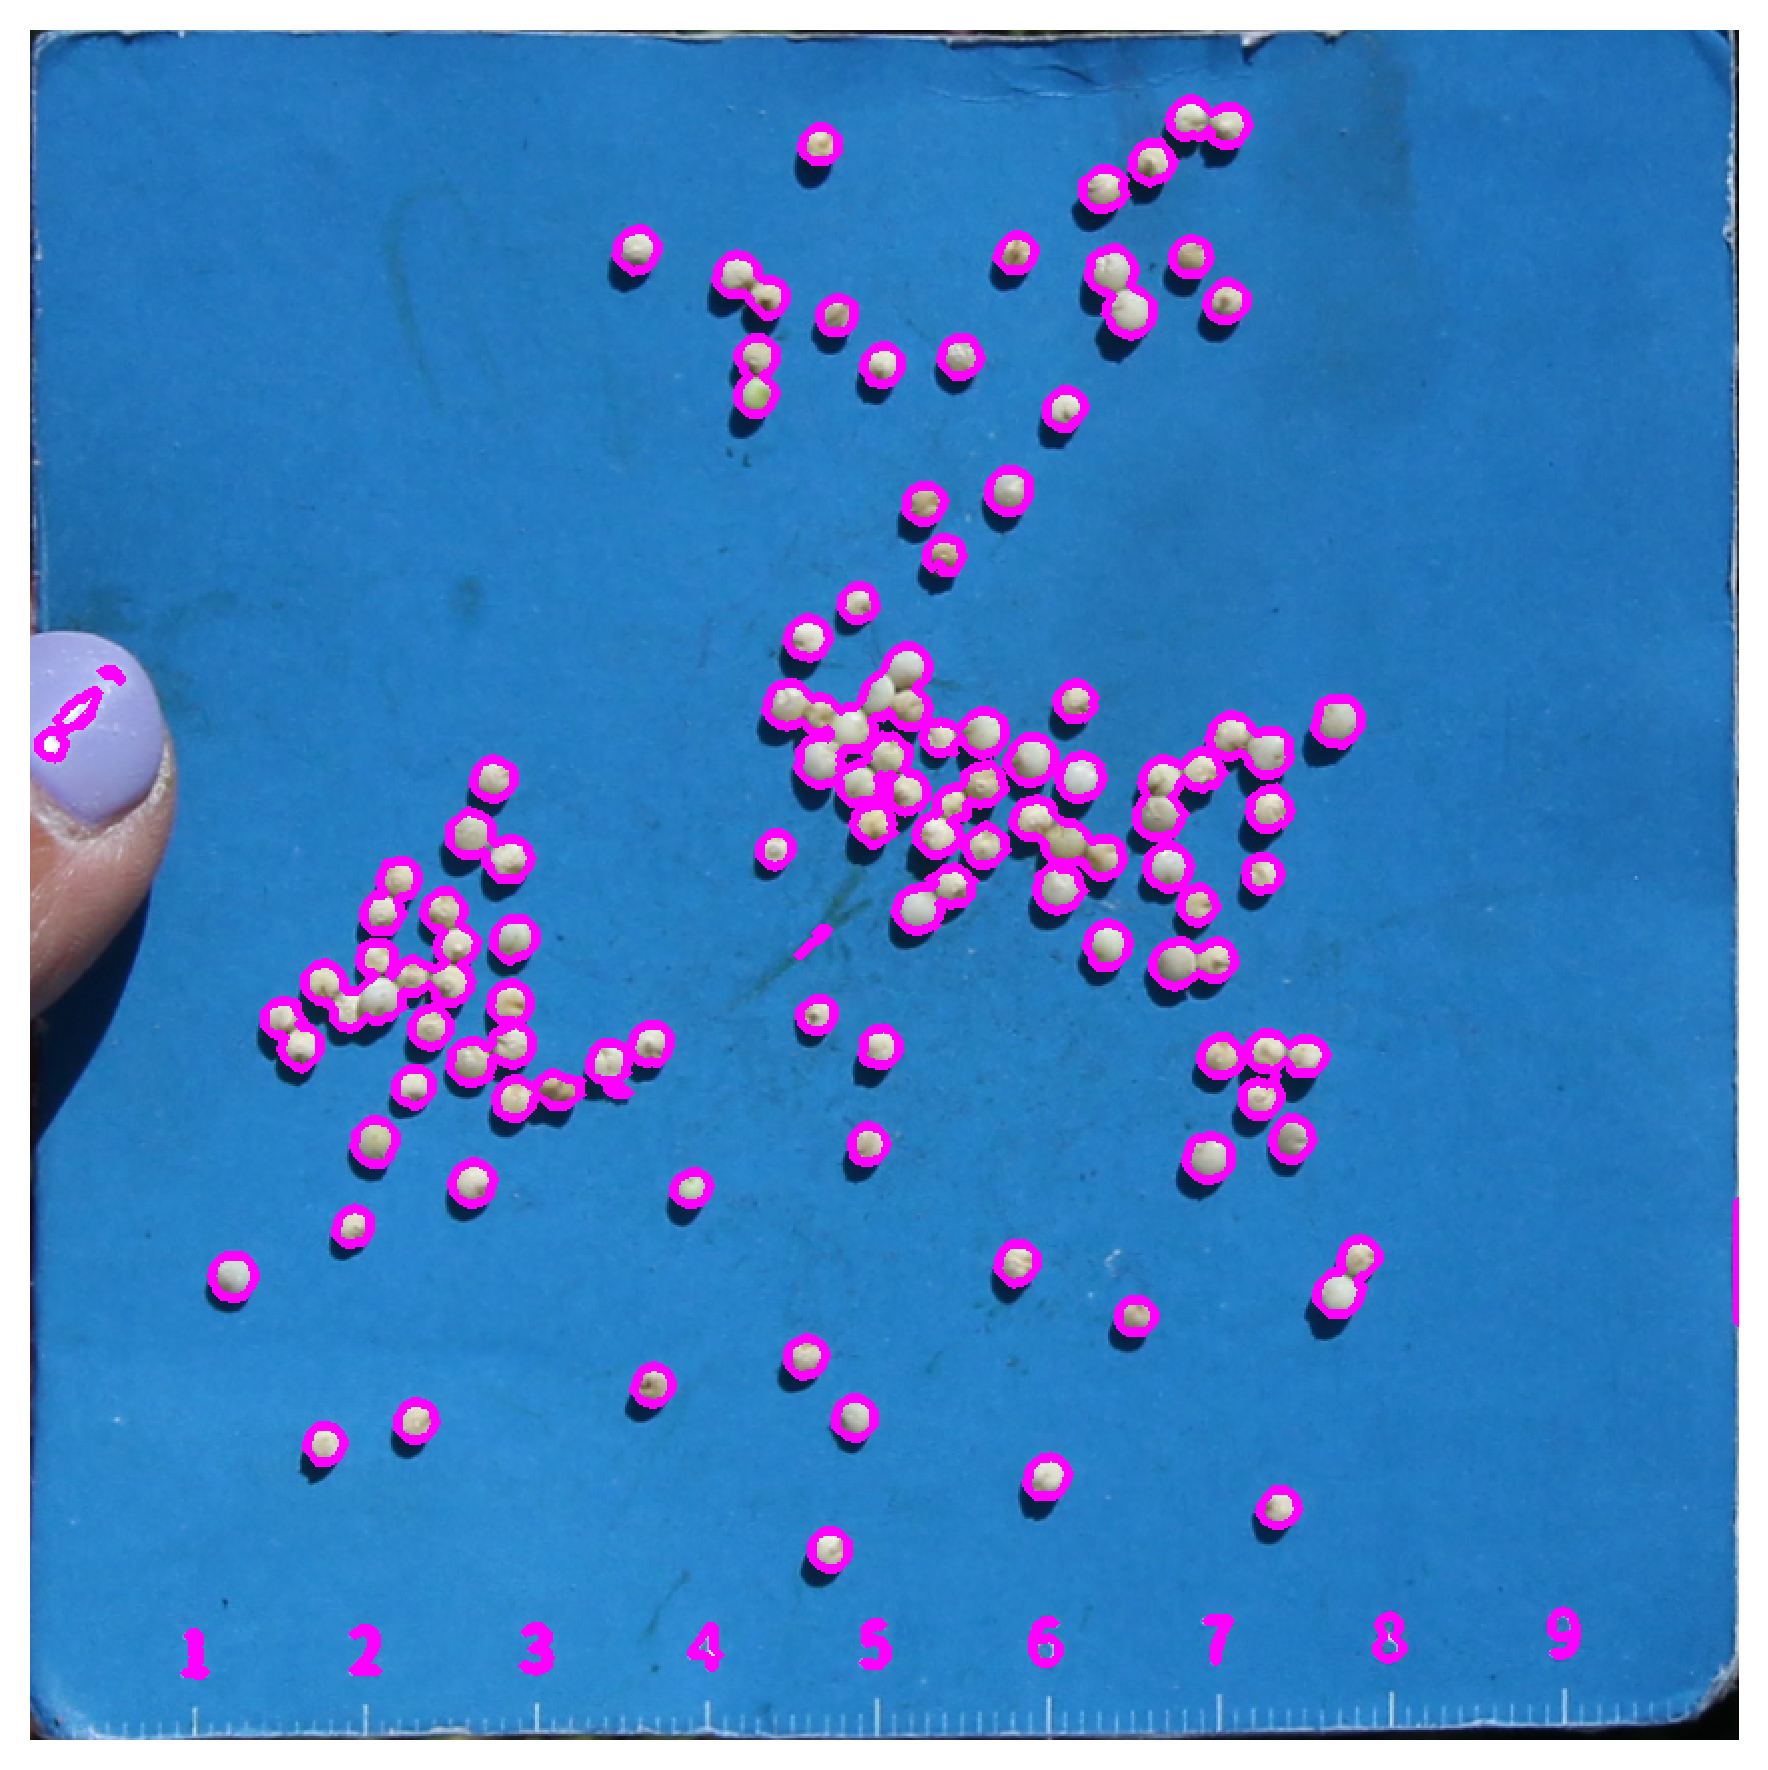

In [21]:
show_contours = img_bgr_cropped.copy()

show_contours = cv.drawContours(show_contours, list(marker_contours.values()), -1, q.MAGENTA, 3)

q.show_image(show_contours)

In [22]:
marker_moments = {marker: cv.moments(contour) for marker, contour in marker_contours.items()}
marker_perimeters = {marker: cv.arcLength(contour, closed=True) for marker, contour in marker_contours.items()}
marker_areas = {marker: cv.contourArea(contour) for marker, contour in marker_contours.items()}

marker_eccentricities = {}
for marker, contour in marker_contours.items():
    (x,y),(minor_axis, major_axis),angle = cv.fitEllipse(contour)
    marker_eccentricities[marker] = np.sqrt(1 - ((minor_axis / major_axis) ** 2))

[117.9827550649643, 58.870057225227356, 71.5979790687561, 72.18376553058624, 70.76955199241638, 61.11269783973694, 62.870057225227356, 135.29646337032318, 110.32590091228485, 64.5269113779068, 59.21320307254791, 115.39696860313416, 65.11269783973694, 64.87005722522736, 65.11269783973694, 70.28427076339722, 63.69848430156708, 64.87005722522736, 58.870057225227356, 69.35533845424652, 529.7716399431229, 26.727921843528748, 62.76955199241638, 122.81118214130402, 79.11269783973694, 128.71067690849304, 122.81118214130402, 78.18376553058624, 173.92387998104095, 74.76955199241638, 67.11269783973694, 168.02438521385193, 70.76955199241638, 244.20815074443817, 71.5979790687561, 135.39696860313416, 67.35533845424652, 54.28427076339722, 74.76955199241638, 58.870057225227356, 116.66904675960541, 133.88224983215332, 59.11269783973694, 396.81832242012024, 69.35533845424652, 71.94112491607666, 45.69848430156708, 118.22539567947388, 199.92387998104095, 56.62741661071777, 110.32590091228485, 64.526911377

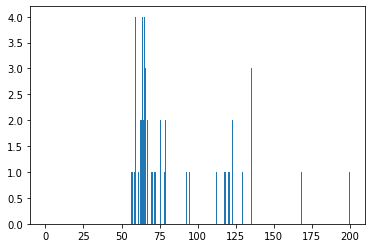

In [23]:
perimeters = list(marker_perimeters.values())
print(perimeters)
plt.hist(perimeters, range = (0, 200), bins = 500)
plt.show()

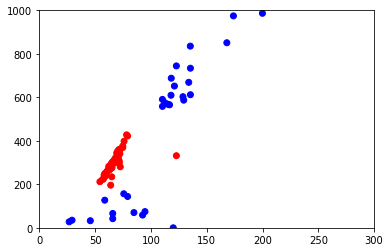

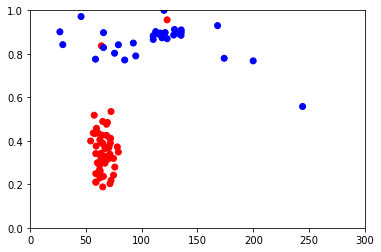

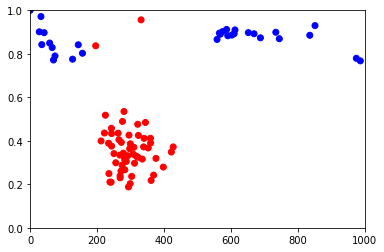

In [24]:
x = p = np.array([marker_perimeters[m] for m in good_markers])
y = a = np.array([marker_areas[m] for m in good_markers])
z = e = np.array([marker_eccentricities[m] for m in good_markers])
c = ['red' if int(np.round(marker_areas[m] / better_seed_area)) == 1 else 'blue' for m in good_markers]
plt.scatter(x, y, c=c)
plt.gca().set_xlim(0, 300)
plt.gca().set_ylim(0, 1000)
plt.show()

plt.scatter(x, z, c=c)
plt.gca().set_xlim(0, 300)
plt.gca().set_ylim(0, 1)
plt.show()

plt.scatter(y, z, c=c)
plt.gca().set_xlim(0, 1000)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
pae = np.stack([p, a, e], axis = -1)
print(pae.shape)

mix = mixtures.GaussianMixture(n_components = 8, max_iter = 1000)
clusters = mix.fit_predict(pae)
print(clusters)

(89, 3)
[6 0 0 0 0 0 0 2 6 0 0 6 0 0 0 0 0 0 0 0 3 4 0 4 0 6 2 0 7 0 0 2 0 5 0 2 0
 0 0 0 6 6 0 1 0 0 4 2 7 0 6 0 6 0 6 0 0 6 0 4 0 0 0 0 0 0 4 0 6 0 0 0 0 0
 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4]


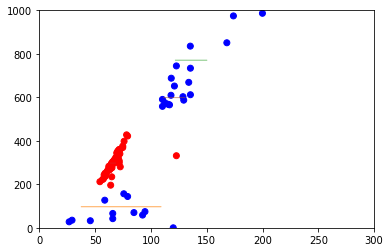

In [26]:
x = p = np.array([marker_perimeters[m] for m in good_markers])
y = a = np.array([marker_areas[m] for m in good_markers])
m01 = np.array([marker_moments[m]['m01'] for m in good_markers])
m10 = np.array([marker_moments[m]['m01'] for m in good_markers])
c = ['red' if int(np.round(marker_areas[m] / better_seed_area)) == 1 else 'blue' for m in good_markers]
plt.scatter(x, y, c=c)

for idx, (mean, covar) in enumerate(zip(mix.means_, mix.covariances_)):
    v, w = np.linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=q.HTML_COLORS[idx])
    ell.set_alpha(0.5)
    plt.gca().add_artist(ell)

plt.gca().set_xlim(0, 300)
plt.gca().set_ylim(0, 1000)
plt.show()

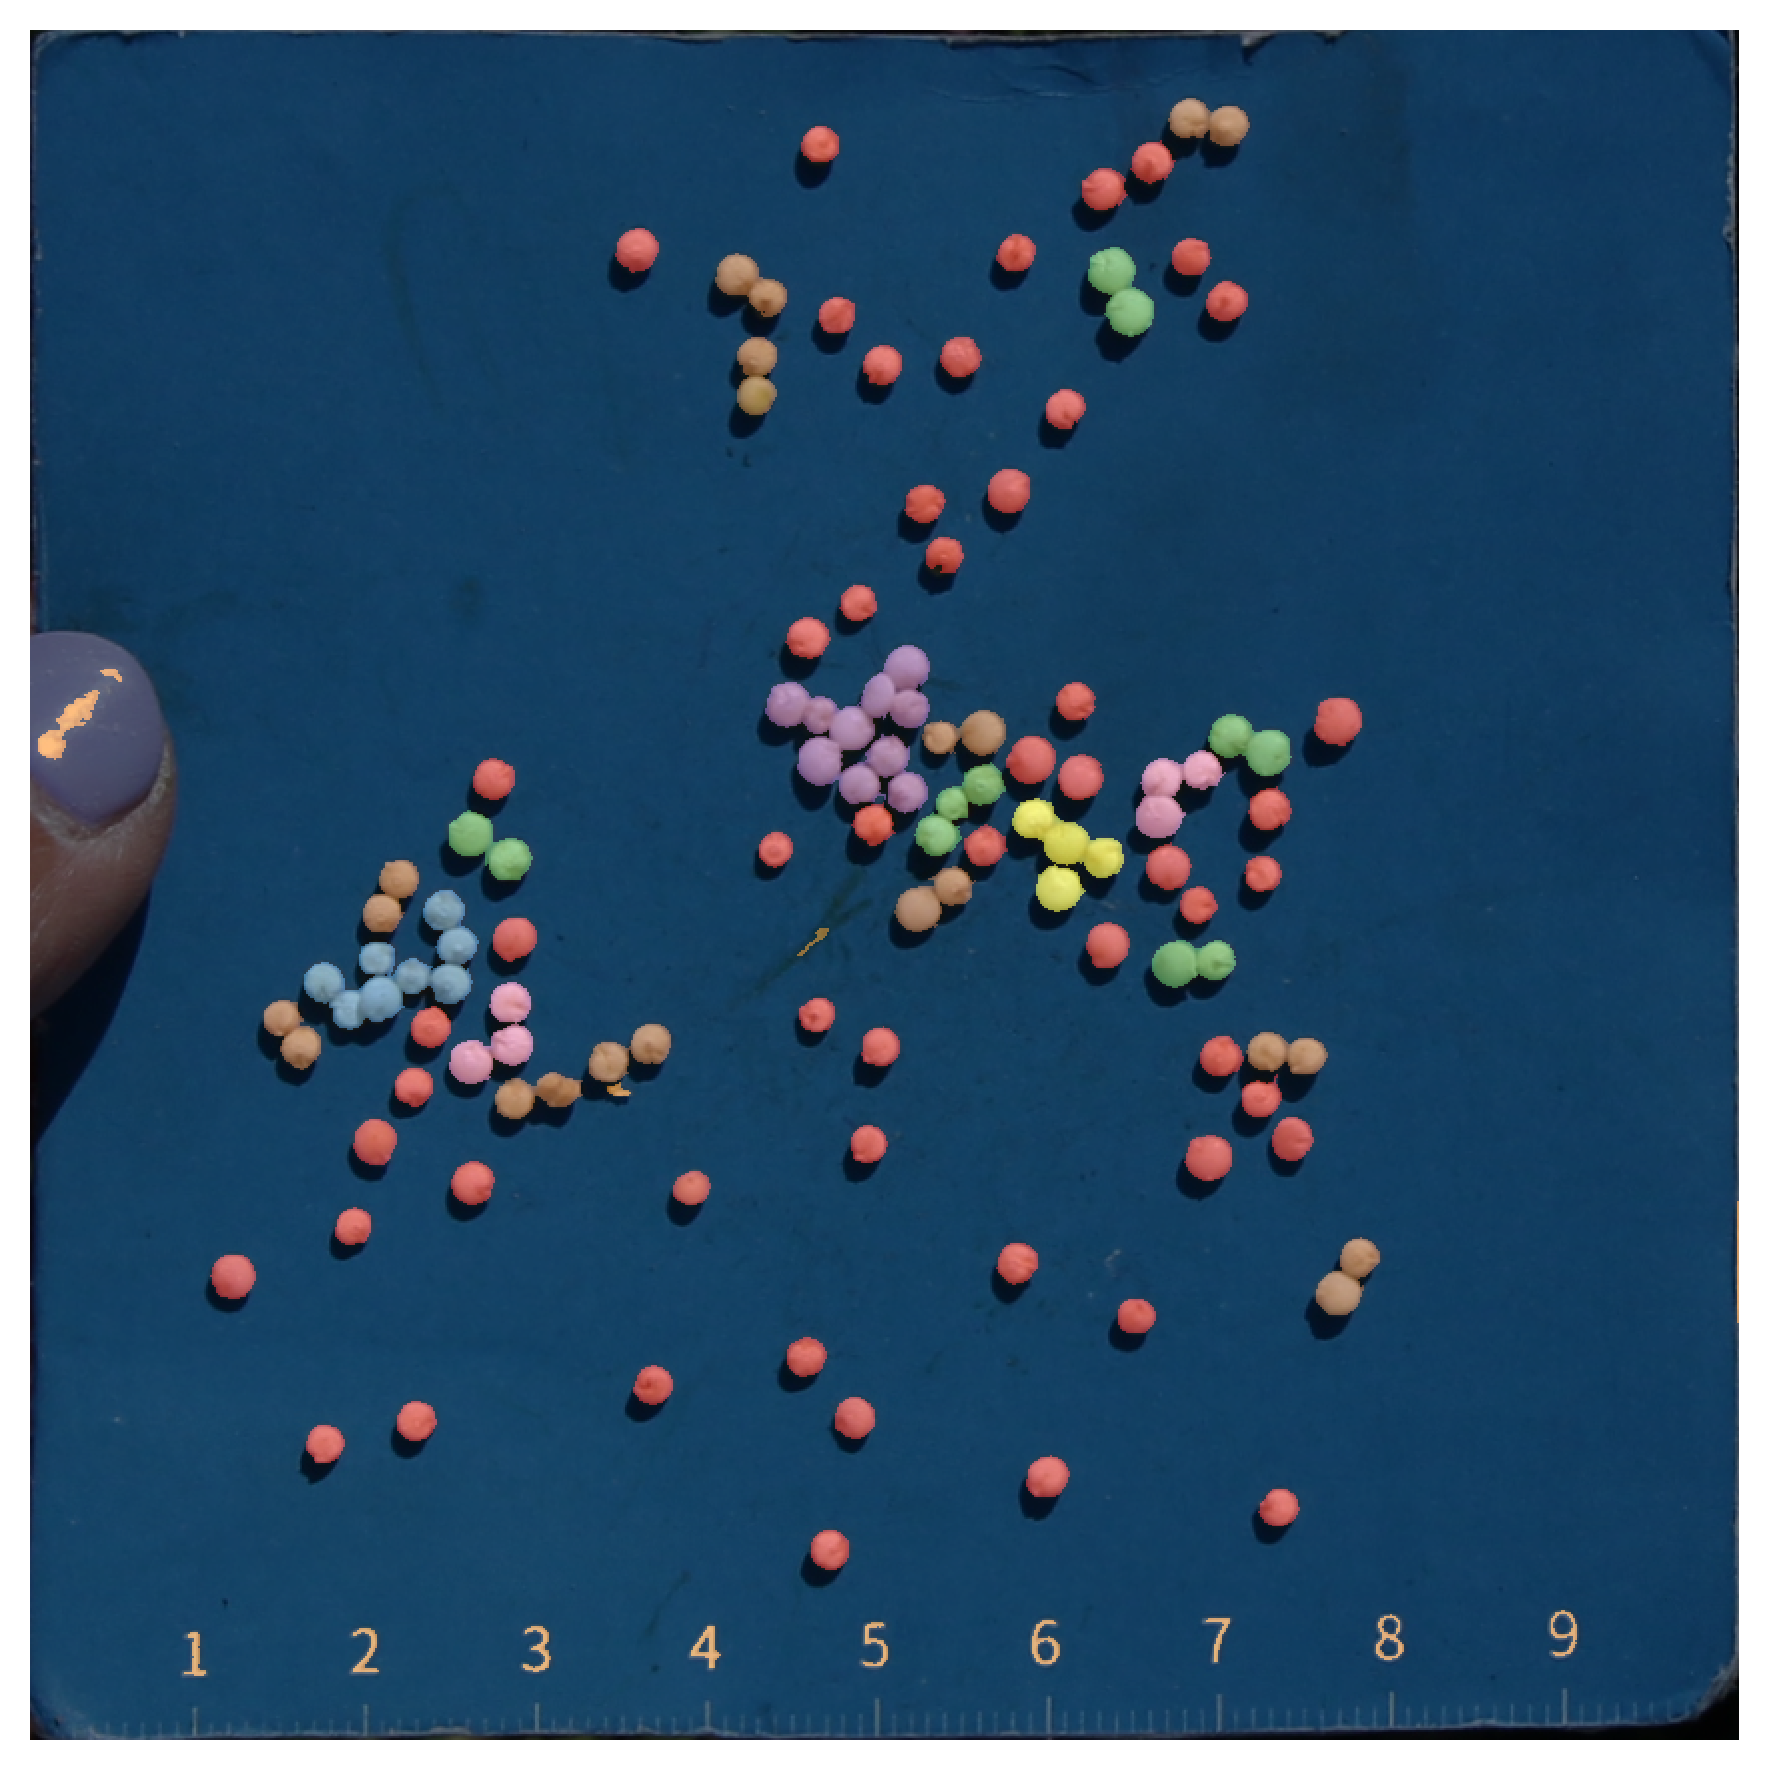

In [27]:
show_clusters = np.zeros_like(img_bgr_cropped)

for marker, cluster in zip(good_markers, clusters):
    show_clusters[seed_labels == marker] = q.BGR_COLORS[cluster]

q.show_image(q.overlay_image(img_bgr_cropped, show_clusters))